## Pickleball Game Predictor

I play pickleball every week with a group of friends: Taylor, Becca, Alex and Tori. Being the competitive people we are, we began recording our wins and losses in a spreadsheet. I built this app to see if I could use machine learning to predict who would win based on parameters of the game. Below is the model development. The dataset is small and highly sparse, making this a difficult problem for classic ML techniques. This is reflected in the generally poor performance of the model. Still, it picks up on some importance patterns, and more importantly, gives us a neutral third party answer to the ultimate question: who will win?

### Set Up

In [1]:
# Base
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import plot_tree

# Custom
from utils import clean_data

%load_ext autoreload
%autoreload 2

### Load Data and Clean 

See `utils.py` for specific data cleaning steps.

In [2]:
# load data
path = 'data/Pickleball - Sheet1.csv'
data_raw = pd.read_csv(path, header = None)

In [3]:
# clean data
data_clean = clean_data(data_raw)

/Users/jharwood/Desktop/pickleball-app/backend/utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clean_data.court_time = pd.to_datetime(clean_data.court_time)
/Users/jharwood/Desktop/pickleball-app/backend/utils.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clean_data.game_end_times = pd.to_datetime(clean_data.game_end_times)


### Feature Engineering

I created a few features based on qualitative assessment of what matters. We all have varying degrees of stamina so longer games can benefit some more than others, hence recording the length of the game. Additionally, some of us excel at different times of the day, hence the "hour" variable.

In [4]:
# create features

features = data_clean.copy()

# Create game length variables
features['game_length'] = features.groupby(['Date']).game_end_times.diff().fillna(features.game_end_times - features.court_time)  # first game will be end time - court start time
features['game_length_mins'] = features.game_length.dt.total_seconds()/60

# Create serve variable
features['becca_start'] = np.where(features['Start_2']== 'Y', True, False)

# Create hour variable
features['month'] = features.Date.dt.month
features['hour'] = features.court_time.dt.hour

# Create winner variable (outcome)
features['becca_win'] = features.Score_1 < features.Score_2

# drop unneeded vars
features = features.drop(['Date', 'game_end_times', 'Start_1', 'Start_2', 'Score_1', 'Score_2', 'Incomplete'], axis = 1)

#### Inspect data and visualize

In [5]:
features.head()

1,Day,Park,Court,court_time,game_num,Player_A_1,Player_A_2,Paddle,Player_B_1,Player_B_2,Paddle2,game_length,game_length_mins,becca_start,month,hour,becca_win
2,Sunday,Plummer Park,6B,2025-01-29 14:00:00,1,Julianna,Alex,Straight,Becca,Justin,Bisexual,0 days 00:38:00,38.0,False,9,14,True
3,Sunday,Plummer Park,6B,2025-01-29 14:00:00,2,Julianna,Alex,Straight,Becca,Stig,Bisexual,0 days 00:53:00,53.0,False,9,14,False
4,Tuesday,Roxbury Tennis Club,2,2025-01-29 18:00:00,1,Julianna,None,Straight,Becca,None,Bisexual,0 days 00:26:00,26.0,True,9,18,True
5,Tuesday,Roxbury Tennis Club,2,2025-01-29 18:00:00,2,Julianna,None,Straight,Becca,None,Bisexual,0 days 00:10:00,10.0,True,9,18,True
6,Tuesday,Roxbury Tennis Club,2,2025-01-29 18:00:00,3,Julianna,None,Straight,Becca,None,Bisexual,0 days 00:21:00,21.0,True,9,18,False


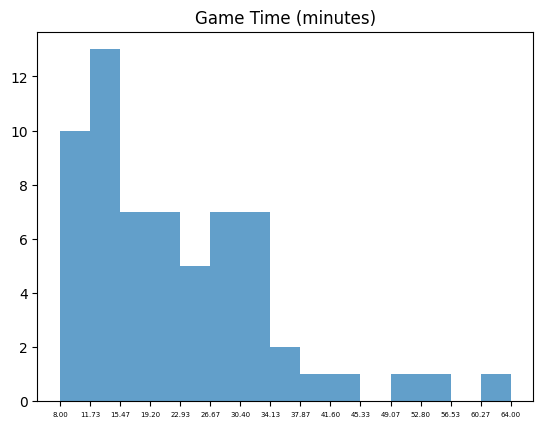

In [6]:
# how is game time distributed?

n, bins, edges = plt.hist(features.game_length_mins, bins=15, ec="red", alpha=0.7)
plt.xticks(bins, fontsize=5)
plt.title("Game Time (minutes)")
plt.show()

### Feature Selection

Typically Becca and I will play on different teams as we are the strongest players. I exploited this pattern to reduce the sparsity of the data by only looking at games where we opposed eachother and using two features, the second player on my team and the second player on Becca's team, to define the full teams (any other games were removed from the data during the data cleaning step). 

To further reduce the dimensionality, I decided to choose just two other features to start with:

* The number game of the session, `game_num` (measure of how warmed up and tired we are)
* Which team serves first, mine or Beccas `becca_start`

In [7]:
simple_model_features = features[['game_num','Player_A_2','Player_B_2','becca_start','becca_win']]

In [8]:
simple_model_features.head()

1,game_num,Player_A_2,Player_B_2,becca_start,becca_win
2,1,Alex,Justin,False,True
3,2,Alex,Stig,False,False
4,1,None,None,True,True
5,2,None,None,True,True
6,3,None,None,True,False


#### Create dummy variables for players

In [9]:
simple_model_features = pd.get_dummies(simple_model_features)

In [10]:
simple_model_features.head()

,game_num,becca_start,becca_win,Player_A_2_Alex,Player_A_2_None,Player_A_2_Taylor,Player_A_2_Tori,Player_B_2_Alex,Player_B_2_Justin,Player_B_2_None,Player_B_2_Stig,Player_B_2_Tay,Player_B_2_Taylor,Player_B_2_Tori
2,1,False,True,True,False,False,False,False,True,False,False,False,False,False
3,2,False,False,True,False,False,False,False,False,False,True,False,False,False
4,1,True,True,False,True,False,False,False,False,True,False,False,False,False
5,2,True,True,False,True,False,False,False,False,True,False,False,False,False
6,3,True,False,False,True,False,False,False,False,True,False,False,False,False


### Modeling

First, I split the data into training and testing, stratifying on the labels to ensure balance.

In [11]:
X = simple_model_features.drop('becca_win', axis=1)
y = simple_model_features['becca_win']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

# Check class distribution in train and test sets
print("Class distribution in the training set:")
print(y_train.value_counts())
print("\nClass distribution in the test set:")
print(y_test.value_counts())


Class distribution in the training set:
becca_win
False    26
True     18
Name: count, dtype: int64

Class distribution in the test set:
becca_win
False    11
True      8
Name: count, dtype: int64


Next, I tune a Random Forest classifier. I chose a Random Forest because I didn't want to assume linearity between the features and label and they perform well with small datasets.

In [12]:
# Define the parameter grid to search
param_grid = {
    'max_depth': [2, 4],  # Maximum depth of the trees
    'min_samples_split': [2, 3],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 3]  # Minimum number of samples required at each leaf node
}

# Create a Random Forest classifier
rf = RandomForestClassifier(random_state = 42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, scoring = 'roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 4], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3]},
             scoring='roc_auc')

#### Model Evaluation

In [13]:
best_rf = grid_search.best_estimator_

print("Best params")
print(grid_search.best_params_)

y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

Best params
{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3}
              precision    recall  f1-score   support

       False       0.65      1.00      0.79        11
        True       1.00      0.25      0.40         8

    accuracy                           0.68        19
   macro avg       0.82      0.62      0.59        19
weighted avg       0.80      0.68      0.62        19



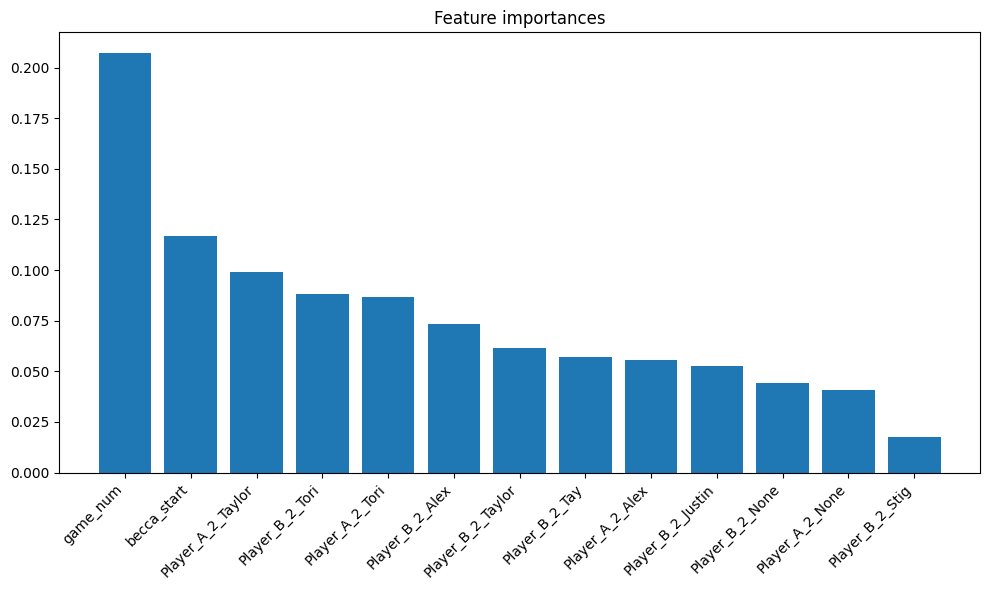

In [14]:
# Visualize variable importance

# Get feature importances
importances = best_rf.feature_importances_
features = X.columns.tolist()

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize = (10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align = "center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation = 45, ha = "right")
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()


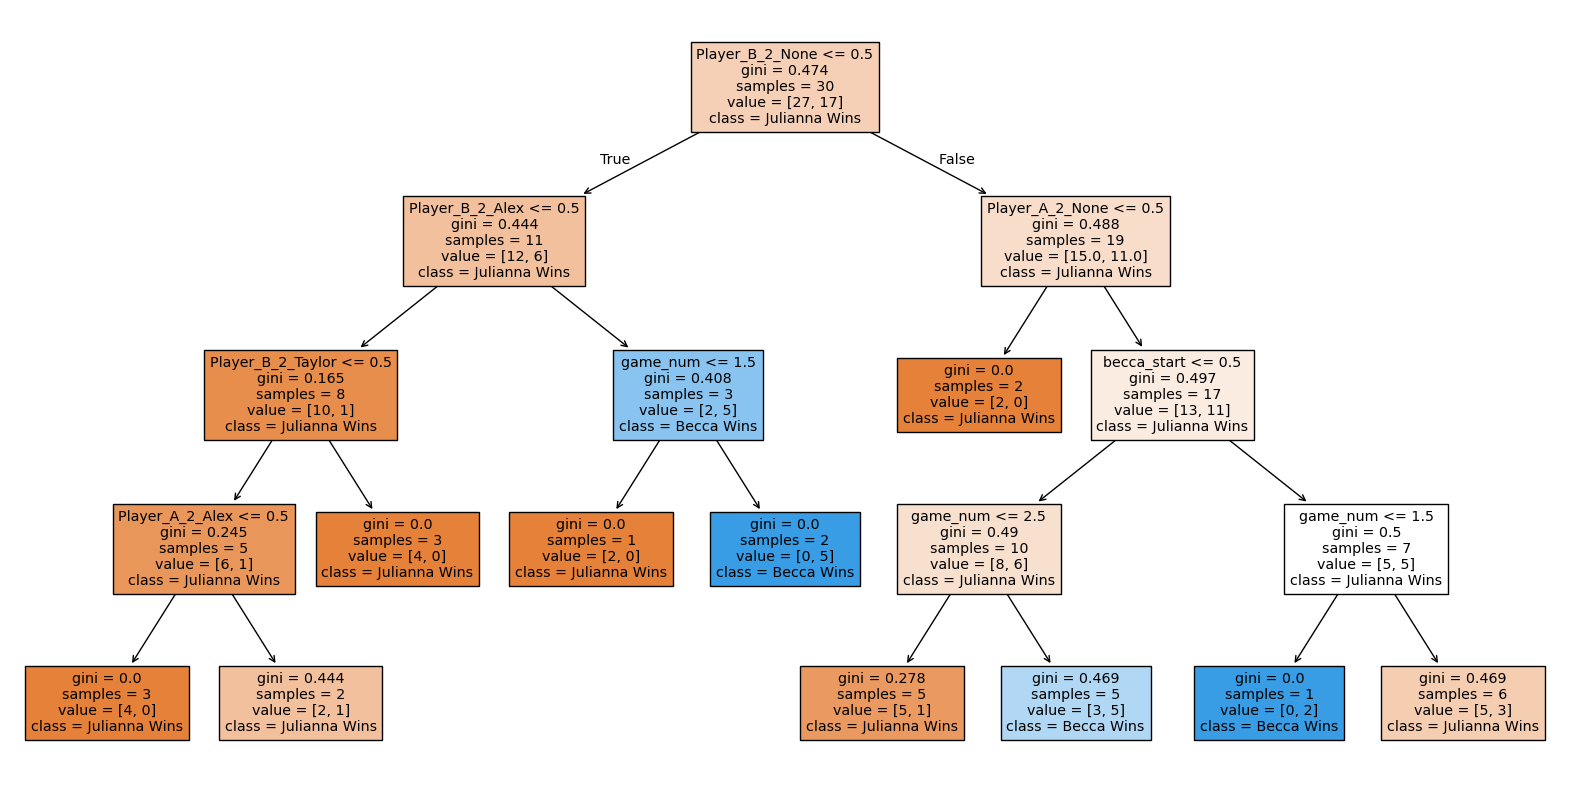

In [15]:
# Visualize a single decision tree from the forest
plt.figure(figsize = (20, 10))
plot_tree(best_rf.estimators_[14], feature_names = features,
          class_names = ['Julianna Wins','Becca Wins'], 
          filled = True)
plt.show()

In [16]:
# Save the best model to a file
joblib.dump(best_rf, 'models/rf.joblib')

['models/rf.joblib']